In [2]:
## helpful packages
import pandas as pd
import numpy as np
import random
import re
import string
import requests
import plotnine 
from plotnine import *
import matplotlib.pyplot as plt
import yaml
#import warnings
#warnings.filterwarnings("ignore")

## sklearn imports
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

## print mult things
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"



In [3]:

addresses_df = pd.read_csv('nodes-addresses.csv')
entities_df = pd.read_csv('nodes-entities.csv')
intermediaries_df = pd.read_csv('nodes-intermediaries.csv') # do not use
officers_df = pd.read_csv('nodes-officers.csv') # do not use 
relationships_df = pd.read_csv('relationships.csv')

/var/folders/5x/0sqjbpy13p3gzjlddpxqjtfw0000gn/T/ipykernel_15046/2313704109.py:2: DtypeWarning: Columns (2,3,6,7,10,11,12,13,14,15,16,17,20) have mixed types. Specify dtype option on import or set low_memory=False.
/var/folders/5x/0sqjbpy13p3gzjlddpxqjtfw0000gn/T/ipykernel_15046/2313704109.py:5: DtypeWarning: Columns (4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.


In [4]:
relationships_df.head()
entities_df.head()
addresses_df.head()


,node_id_start,node_id_end,rel_type,link,status,start_date,end_date,sourceID
0,10002580,14106952,registered_address,registered address,NaN,NaN,NaN,Panama Papers
1,10004460,14101133,registered_address,registered address,NaN,NaN,NaN,Panama Papers
2,10023813,14105100,registered_address,registered address,NaN,NaN,NaN,Panama Papers
3,10023840,14100712,registered_address,registered address,NaN,NaN,NaN,Panama Papers
4,10010428,14093957,registered_address,registered address,NaN,NaN,NaN,Panama Papers


,node_id,name,original_name,former_name,jurisdiction,jurisdiction_description,company_type,address,internal_id,incorporation_date,...,struck_off_date,dorm_date,status,service_provider,ibcRUC,country_codes,countries,sourceID,valid_until,note
0,10000001,"TIANSHENG INDUSTRY AND TRADING CO., LTD.","TIANSHENG INDUSTRY AND TRADING CO., LTD.",NaN,SAM,Samoa,NaN,ORION HOUSE SERVICES (HK) LIMITED ROOM 1401; 1...,1001256.0,23-MAR-2006,...,15-FEB-2013,NaN,Defaulted,Mossack Fonseca,25221,HKG,Hong Kong,Panama Papers,The Panama Papers data is current through 2015,NaN
1,10000002,"NINGBO SUNRISE ENTERPRISES UNITED CO., LTD.","NINGBO SUNRISE ENTERPRISES UNITED CO., LTD.",NaN,SAM,Samoa,NaN,ORION HOUSE SERVICES (HK) LIMITED ROOM 1401; 1...,1001263.0,27-MAR-2006,...,15-FEB-2014,NaN,Defaulted,Mossack Fonseca,25249,HKG,Hong Kong,Panama Papers,The Panama Papers data is current through 2015,NaN
2,10000003,"HOTFOCUS CO., LTD.","HOTFOCUS CO., LTD.",NaN,SAM,Samoa,NaN,ORION HOUSE SERVICES (HK) LIMITED ROOM 1401; 1...,1000896.0,10-JAN-2006,...,15-FEB-2012,NaN,Defaulted,Mossack Fonseca,24138,HKG,Hong Kong,Panama Papers,The Panama Papers data is current through 2015,NaN
3,10000004,"SKY-BLUE GIFTS & TOYS CO., LTD.","SKY-BLUE GIFTS & TOYS CO., LTD.",NaN,SAM,Samoa,NaN,ORION HOUSE SERVICES (HK) LIMITED ROOM 1401; 1...,1000914.0,06-JAN-2006,...,15-FEB-2009,NaN,Defaulted,Mossack Fonseca,24012,HKG,Hong Kong,Panama Papers,The Panama Papers data is current through 2015,NaN
4,10000005,FORTUNEMAKER INVESTMENTS CORPORATION,FORTUNEMAKER INVESTMENTS CORPORATION,NaN,SAM,Samoa,NaN,LOYAL PORT LIMITED 8/F; CRAWFORD TOWER 99 JERV...,1001266.0,19-APR-2006,...,15-FEB-2008,NaN,Changed agent,Mossack Fonseca,R25638,HKG,Hong Kong,Panama Papers,The Panama Papers data is current through 2015,NaN


,node_id,address,name,countries,country_codes,sourceID,valid_until,note
0,24000001,"ANNEX FREDERICK & SHIRLEY STS, P.O. BOX N-4805...",NaN,Bahamas,BHS,Bahamas Leaks,The Bahamas Leaks data is current through earl...,NaN
1,24000002,"SUITE E-2,UNION COURT BUILDING, P.O. BOX N-818...",NaN,Bahamas,BHS,Bahamas Leaks,The Bahamas Leaks data is current through earl...,NaN
2,24000003,"LYFORD CAY HOUSE, LYFORD CAY, P.O. BOX N-7785,...",NaN,Bahamas,BHS,Bahamas Leaks,The Bahamas Leaks data is current through earl...,NaN
3,24000004,"P.O. BOX N-3708 BAHAMAS FINANCIAL CENTRE, P.O....",NaN,Bahamas,BHS,Bahamas Leaks,The Bahamas Leaks data is current through earl...,NaN
4,24000005,"LYFORD CAY HOUSE, 3RD FLOOR, LYFORD CAY, P.O. ...",NaN,Bahamas,BHS,Bahamas Leaks,The Bahamas Leaks data is current through earl...,NaN


### Alternate merging style

In [5]:

rels = pd.read_csv("relationships.csv")

# Read each node file, add a 'node_type' column
addresses       = pd.read_csv("nodes-addresses.csv"     ).assign(node_type="address")
entities        = pd.read_csv("nodes-entities.csv"      ).assign(node_type="entity")
intermediaries  = pd.read_csv("nodes-intermediaries.csv").assign(node_type="intermediary")
officers        = pd.read_csv("nodes-officers.csv"      ).assign(node_type="officer")

# Stack them into one DataFrame
nodes = pd.concat(
    [addresses, entities, intermediaries, officers],
    ignore_index=True,
    sort=False
)

# Merge in the metadata for the 'start' node
#    Suffix all node columns with '_start'; this brings in, e.g., name_start, countries_start, node_type_start, etc.
rels = rels.merge(
    nodes.add_suffix("_start"),
    left_on="node_id_start",
    right_on="node_id_start",
    how="left"
)

# Merge in the metadata for the 'end' node
#    Suffixing with '_end' brings in name_end, countries_end, node_type_end, etc.
rels = rels.merge(
    nodes.add_suffix("_end"),
    left_on="node_id_end",
    right_on="node_id_end",
    how="left"
)

print(rels.info())


/var/folders/5x/0sqjbpy13p3gzjlddpxqjtfw0000gn/T/ipykernel_15046/3933989109.py:1: DtypeWarning: Columns (4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
/var/folders/5x/0sqjbpy13p3gzjlddpxqjtfw0000gn/T/ipykernel_15046/3933989109.py:5: DtypeWarning: Columns (2,3,6,7,10,11,12,13,14,15,16,17,20) have mixed types. Specify dtype option on import or set low_memory=False.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3339267 entries, 0 to 3339266
Data columns (total 50 columns):
 #   Column                          Dtype 
---  ------                          ----- 
 0   node_id_start                   int64 
 1   node_id_end                     int64 
 2   rel_type                        object
 3   link                            object
 4   status                          object
 5   start_date                      object
 6   end_date                        object
 7   sourceID                        object
 8   address_start                   object
 9   name_start                      object
 10  countries_start                 object
 11  country_codes_start             object
 12  sourceID_start                  object
 13  valid_until_start               object
 14  note_start                      object
 15  node_type_start                 object
 16  original_name_start             object
 17  former_name_start               object
 18  ju

In [6]:
rels.head()
len(rels)



,node_id_start,node_id_end,rel_type,link,status,start_date,end_date,sourceID,address_start,name_start,...,jurisdiction_description_end,company_type_end,internal_id_end,incorporation_date_end,inactivation_date_end,struck_off_date_end,dorm_date_end,status_end,service_provider_end,ibcRUC_end
0,10002580,14106952,registered_address,registered address,NaN,NaN,NaN,Panama Papers,STEMBRIDGE TRUST (IRELAND) LIMITED 5 THE COURT...,FUSION TRADING LIMITED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10004460,14101133,registered_address,registered address,NaN,NaN,NaN,Panama Papers,MF CORPORATE (UK) LIMITED 520 S. 7TH STREET S...,MF CORPORATE (UK) LIMITED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10023813,14105100,registered_address,registered address,NaN,NaN,NaN,Panama Papers,REIG INVESTMENTS LLP INVISION HOUSE WILBURY WA...,REIG INVESTMENTS LLP,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10023840,14100712,registered_address,registered address,NaN,NaN,NaN,Panama Papers,MARCUSSI INTERNATIONAL LLP INVISION HOUSE WILB...,MARCUSSI INTERNATIONAL LLP,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10010428,14093957,registered_address,registered address,NaN,NaN,NaN,Panama Papers,COLLYER BRISTOW LLP SOLICITORS 4 BEDFORD ROW L...,PULSAR HOLDINGS CORPORATION,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


3339267

In [7]:
## Code to s
# rels.to_csv("rels.csv", index=False)

In [8]:
# dropping unnecessary columns from dataset

rels.drop(columns=["status", "start_date", "end_date", "note_start", "dorm_date_start", "valid_until_end", "valid_until_start", "note_start", "note_end"], inplace=True)

Top 10 countries for entities (based on start_country, semicolon separated values counted individually):
countries_start
British Virgin Islands    93349
Malta                     83981
Barbados                  48090
Bermuda                   17324
Hong Kong                 15383
Cayman Islands            14856
United Kingdom            10001
United States              7934
Russia                     7508
Isle of Man                4103
Name: count, dtype: int64


<Axes: xlabel='countries_start'>

Text(0.5, 1.0, 'Top 10 Countries for Entities to be physically based in')

Text(0.5, 0, 'Country')

Text(0, 0.5, 'Number of Entities')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'British Virgin Islands'),
  Text(1, 0, 'Malta'),
  Text(2, 0, 'Barbados'),
  Text(3, 0, 'Bermuda'),
  Text(4, 0, 'Hong Kong'),
  Text(5, 0, 'Cayman Islands'),
  Text(6, 0, 'United Kingdom'),
  Text(7, 0, 'United States'),
  Text(8, 0, 'Russia'),
  Text(9, 0, 'Isle of Man')])

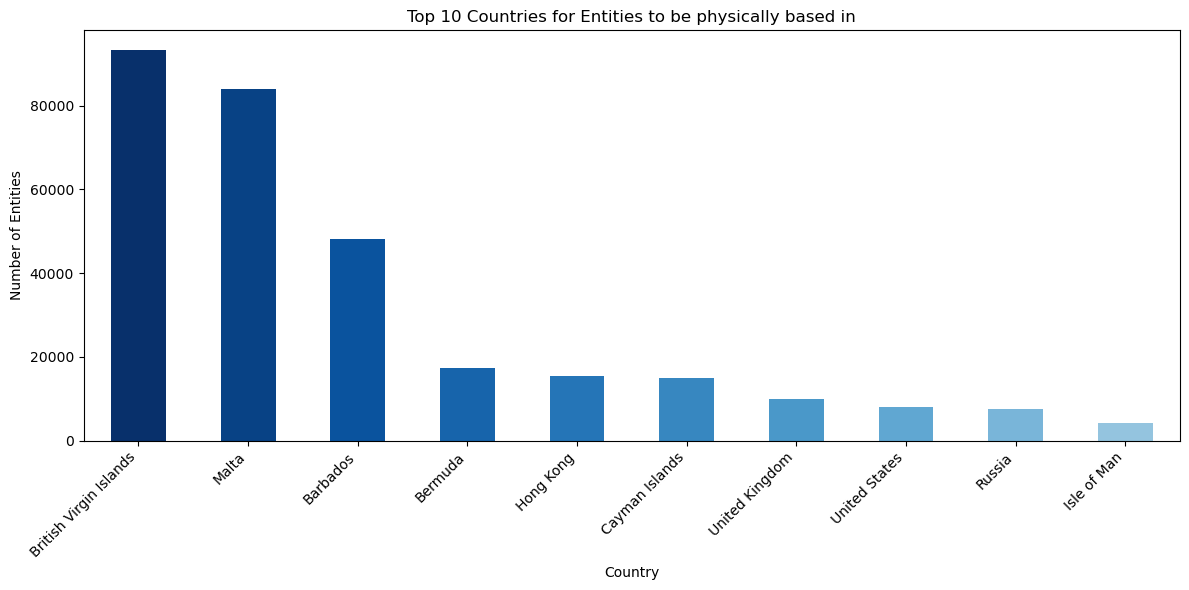

In [18]:
# Filter for entities
entity_rels = rels[rels['node_type_start'] == 'entity']

# Create a new series by splitting countries_start by semicolon and exploding the list
# This handles NaN values by first filling them with an empty string, then filtering out empty strings after split
split_countries = entity_rels['countries_start'].fillna('').str.split(';').explode()

# Remove any empty strings that might result from splitting or from original NaNs
split_countries = split_countries[split_countries != '']

# Get the top 10 countries for entities
value_counts = split_countries.value_counts()
# Filter out "Not identified" before getting the top 10
filtered_value_counts = value_counts[value_counts.index != 'Not identified']
top_10_entity_countries = filtered_value_counts.nlargest(10)

print("Top 10 countries for entities (based on start_country, semicolon separated values counted individually):")
print(top_10_entity_countries)

# Create a bar plot for the top 10 countries
# Sort the data for gradient coloring
sorted_countries = top_10_entity_countries.sort_values(ascending=False)
# Create a color map from light blue to dark blue
colors = plt.cm.Blues(np.linspace(1, 0.4, len(sorted_countries))) # Darkest for highest, lighter for lower

sorted_countries.plot(kind='bar', figsize=(12, 6), color=colors)
plt.title('Top 10 Countries for Entities to be physically based in')
plt.xlabel('Country')
plt.ylabel('Number of Entities')
plt.xticks(rotation=45, ha='right') # Adjusted rotation for better label visibility
plt.tight_layout()
plt.show()


Top 10 jurisdictions for entities (based on jurisdiction_description_start):
jurisdiction_description_start
Malta                     83948
British Virgin Islands    64042
Aruba                     51820
Barbados                  48546
Bahamas                   18241
Bermuda                   16992
Cayman Islands            10915
Isle of Man                3659
Panama                     3416
Samoa                      3326
Name: count, dtype: int64


<Axes: xlabel='jurisdiction_description_start'>

Text(0.5, 1.0, 'Top 10 Jurisdictions for Entities')

Text(0.5, 0, 'Jurisdiction')

Text(0, 0.5, 'Number of Entities')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Malta'),
  Text(1, 0, 'British Virgin Islands'),
  Text(2, 0, 'Aruba'),
  Text(3, 0, 'Barbados'),
  Text(4, 0, 'Bahamas'),
  Text(5, 0, 'Bermuda'),
  Text(6, 0, 'Cayman Islands'),
  Text(7, 0, 'Isle of Man'),
  Text(8, 0, 'Panama'),
  Text(9, 0, 'Samoa')])

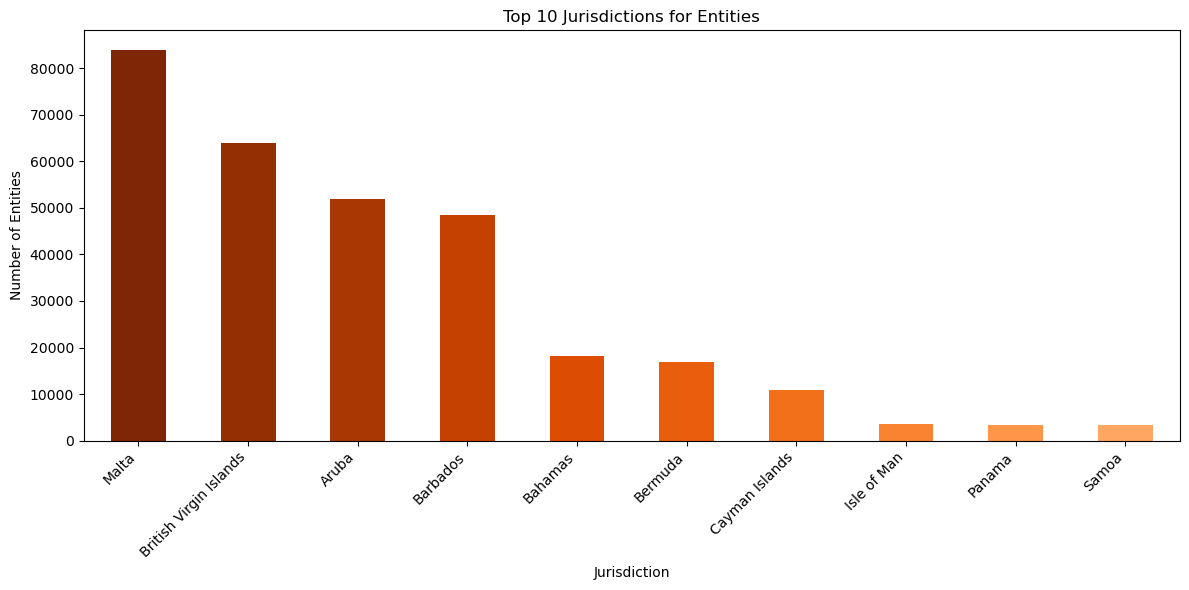

In [ ]:
# Filter for entities
entity_rels = rels[rels['node_type_start'] == 'entity']

# Get the top 10 jurisdictions for entities
jurisdiction_counts = entity_rels['jurisdiction_description_start'].value_counts()
# Filter out "Undetermined" before getting the top 10
filtered_jurisdiction_counts = jurisdiction_counts[jurisdiction_counts.index != 'Undetermined']
top_10_entity_jurisdictions = filtered_jurisdiction_counts.nlargest(10)

print("Top 10 jurisdictions for entities (based on jurisdiction_description_start):")
print(top_10_entity_jurisdictions)

# Create a bar plot for the top 10 jurisdictions
# Sort the data for gradient coloring
sorted_jurisdictions = top_10_entity_jurisdictions.sort_values(ascending=False)
# Create a color map from light orange to dark orange
colors = plt.cm.Oranges(np.linspace(1, 0.4, len(sorted_jurisdictions))) # Darkest for highest, lighter for lower

sorted_jurisdictions.plot(kind='bar', figsize=(12, 6), color=colors)
plt.title('Top 10 Jurisdictions for Entities')
plt.xlabel('Jurisdiction')
plt.ylabel('Number of Entities')
plt.xticks(rotation=45, ha='right') # Added ha='right' for better label visibility
plt.tight_layout()
plt.show()
